This notebook runs the zero-shot experiments in "A Robust and Efficient Stopping Criteria for Systematic Reviews Using Poisson Processes." 

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import math
from scipy.optimize import curve_fit
import random
import glob
import matplotlib.pyplot as plt


# IMPORT EXPERIEMENTAL FUNCTIONS
from utils.read_data_fns import *
from utils.target_method_fns import *  
from utils.inhomogeneous_pp_fns import *   
from utils.eval_fns import *

In [2]:
# READ TOPIC RELEVANCE DATA
with open('data/relevance/qrel_abs_test.txt', 'r') as infile:
    qrels_data = infile.readlines()    
query_rel_dic = make_rel_dic(qrels_data) # make dictionary of list of docids relevant to each queryid
all_runs = glob.glob('data/runs2017_table3/*/*')    


# SET POISSON PROCESS PARAMETERS
sample_props = [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,
                0.7,0.75,0.8,0.85,0.9,0.95,1]  # proportion of docs to sample
min_rel_in_sample = 20 # min number rel docs must be initial sample to proceed with algorithm 
n_windows = 10  # number of windows to male from sample


# SET EXPERIMENTAL PARAMETERS 
des_recalls = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95] # desired recalls to experiment over
des_probs = [0.7, 0.95] # desired probabilities to experiment over

In [3]:
# fn to run stopping methods (baseline, oracle, target method and poisson process over all runs)
def run_sp_algorithms(des_recall, des_prob):
    
    # PREPARE SCORING DICTIONARIES
    run_score_dic = {}
    oracle_dic = {}
    
    # LOOP OVER RUNS
    for run in sorted(all_runs):


        # MAKE DATA DICTIONARIES
        with open(run, 'r') as infile:
            run_data = infile.readlines()
        doc_rank_dic = make_rank_dic(run_data)  # make dictionary of ranked docids for each queryid
        rank_rel_dic = make_rank_rel_dic(query_rel_dic,doc_rank_dic) # make dic of list relevances of ranked docs for each queryid

        # PREPARE SCORING DICTIONARIES
        run_name = run[5:]
        score_dic = {}
        oracle_dic[run_name] = []

        # LOOP OVER TOPICS
        topics_list = make_topics_list(doc_rank_dic,1)  # sort topics by no docs
        for query_id in topics_list:
            score_dic[query_id] = []      

            # EXTRACT COUNTS AND REL LISTS
            n_docs = len(doc_rank_dic[query_id])  # total n. docs in topic
            rel_list = rank_rel_dic[query_id]  # list binary rel of ranked docs 


            # ORACLE
            rel_doc_idxs = np.where(np.array(rel_list) == 1)[0]
            orcale_n_rel = math.ceil(len(rel_doc_idxs)*des_recall)
            oracle_idx = rel_doc_idxs[orcale_n_rel-1]
            oracle_eff = oracle_idx+1
            oracle_dic[run_name].append(oracle_eff)
            
            
            # BASELINE (stop at proportion = to desired recall) 
            n_samp_docs = int(round(n_docs*des_recall))
            bl_recall = calc_recall(rel_list, n_samp_docs)
            bl_effort = n_samp_docs
            bl_accept = calc_accept(bl_recall, des_recall)
            score_dic[query_id].append((bl_recall, bl_effort, bl_accept))



            # TARGET METHOD
            random.seed(1)
            target_size = get_target_size(des_recall, des_prob)
            target_list, examined_list = make_target_set(rel_list, n_docs, target_size)  # get target sample and list all docs examined
            tar_stop_n = get_stopping_target(target_list, n_docs, target_size)  # stopping point
            all_examined_idxs = get_all_target_examined_idxs(examined_list, tar_stop_n)  # list of every doc examined during method
            tar_recall = calc_recall(rel_list, tar_stop_n)
            tar_effort = len(all_examined_idxs) # total effort (inc. sampling)
            tar_accept = calc_accept(tar_recall, des_recall)
            score_dic[query_id].append((tar_recall, tar_effort, tar_accept))

            
        

            # INHOMOGENEOUS POISSON PROCESS
            # check topic meets initial relevance requirement
            n_samp_docs = int(round(n_docs*sample_props[0]))
            sample_rel_list = rel_list[0:n_samp_docs]  # chunck of rel list examined in sample

            # if meet size requirement run algorithm; else return n_docs as stopping point
            if (np.sum(sample_rel_list) >= min_rel_in_sample):

                windows_end_point = 0
                pred_stop_n = n_docs
                i = 0

                while (i < len(sample_props)) and (pred_stop_n > n_samp_docs):
                    sample_prop = sample_props[i]

                    n_samp_docs = int(round(n_docs*sample_props[i]))
                    sample_rel_list = rel_list[0:n_samp_docs]  # chunck of rel list examined in sample

                    # get points
                    windows = make_windows(n_windows, sample_prop, n_docs)
                    window_size = windows[0][1]

                    x,y = get_points(windows, window_size, sample_rel_list)  # calculate points that will be used to fit curve

                    try: # try to fit curve
                        p0 = [0.1, 0.001, 1]  # initialise curve parameters
                        opt, pcov = curve_fit(model_func, x, y, p0)  # fit curve
                        a, k, b = opt
                        y2 = model_func(x, a, k, b) # get y-values for fitted curve

                        # check distance between "curves" at end sample
                        n_rel_at_end_samp = np.sum(sample_rel_list)
                        y3 =  model_func(np.array(range(1,len(sample_rel_list)+1)), a, k, b)
                        est_by_curve_end_samp = np.sum(y3)
                        est_by_curve_end_samp = int(round(est_by_curve_end_samp))


                        if n_rel_at_end_samp >= des_recall*est_by_curve_end_samp:


                            # using inhom Poisson process with fitted curve as rate fn, predict total number rel docs in topic 
                            mu = (a/-k)*(math.exp(-k*n_docs)-1)  # integral model_func
                            pred_n_rel = predict_n_rel(des_prob, n_docs, mu) # predict max number rel docs (using poisson cdf)
                            des_n_rel = des_recall*pred_n_rel
                            if des_n_rel <= n_rel_at_end_samp:
                                pred_stop_n = n_rel_at_end_samp             


                    except: # if can't fit curve
                        pass

                    i += 1  # increase sample proportion size


                # score result 
                inhom_recall = calc_recall(rel_list, n_samp_docs)
                inhom_effort = n_samp_docs
                inhom_accept = calc_accept(inhom_recall, des_recall)
                score_dic[query_id].append((inhom_recall, inhom_effort, inhom_accept))


            else: # if not enough rel docs in min sample, stopping point is n_docs
                inhom_recall = calc_recall(rel_list, n_docs)
                inhom_effort = n_docs
                inhom_accept = calc_accept(inhom_recall, des_recall)
                score_dic[query_id].append((inhom_recall, inhom_effort, inhom_accept))

        # SCORE RESULTS
        tar_accept_vec = [val[1][2] for val in score_dic.values()]
        inhom_accept_vec = [val[2][2] for val in score_dic.values()]
        BL_accept_vec = [val[0][2] for val in score_dic.values()]
        tar_eff_vec = [val[1][1] for val in score_dic.values()]
        inhom_eff_vec = [val[2][1] for val in score_dic.values()]
        BL_eff_vec = [val[0][1] for val in score_dic.values()]
        topic_size_vec = [len(doc_rank_dic[query_id]) for query_id in topics_list]

        
        # ADD SCORES TO DICTIONARIES
        run_score_dic[run_name] = {}
        run_score_dic[run_name]['tar rel'] = calc_reliability(tar_accept_vec)
        run_score_dic[run_name]['in rel'] = calc_reliability(inhom_accept_vec)
        run_score_dic[run_name]['BL rel'] = calc_reliability(BL_accept_vec)
        run_score_dic[run_name]['tar tot eff'] =  np.sum(tar_eff_vec)
        run_score_dic[run_name]['in tot eff'] = np.sum(inhom_eff_vec)
        run_score_dic[run_name]['BL tot eff'] = np.sum(BL_eff_vec)
        run_score_dic[run_name]['oracle eff'] = np.sum(oracle_dic[run_name])
 

    # MAKE DATAFRAME OF ALL RESULTS
    df = pd.DataFrame.from_dict(run_score_dic, orient='index')
    
    return  (df, df.mean().round(2).to_dict())

In [4]:
# RUN EXPERIMENTS
results_dict_verbose = {}
results_dict = {}
for r in des_recalls:
    for p in des_probs:
        results_dict_verbose[(p,r)], results_dict[(p,r)] = run_sp_algorithms(r, p)

/home/alison/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [15]:
# MAKE LATEX TABLE OUTPUT 
df = pd.DataFrame.from_dict(results_dict, orient='index')

def pes(eff):  # fn to calculate % of effort saved
    saving = 117562-eff
    return round(100*saving/117562,1)

df['TM es'] = [pes(eff) for eff in df['tar tot eff'].tolist()]
df['PP es'] = [pes(eff) for eff in df['in tot eff'].tolist()]
df['BL es'] = [pes(eff) for eff in df['BL tot eff'].tolist()]
df['OR es'] = [pes(eff) for eff in df['oracle eff'].tolist()]
df['tar tot eff'] = df['tar tot eff'].astype(int)
df['in tot eff'] = df['in tot eff'].astype(int)
df['BL tot eff'] = df['BL tot eff'].astype(int)
df['oracle eff'] = df['oracle eff'].astype(int)

df = df.sort_index()
df

tar rel  in rel  BL rel  tar tot eff  in tot eff  BL tot eff  \
0.70 0.50     0.86    0.97    0.91        51349       59881       58525   
     0.60     0.87    0.95    0.90        59810       60911       70231   
     0.70     0.83    0.93    0.91        64044       63107       81935   
     0.80     0.81    0.91    0.92        71567       67480       93641   
     0.90     0.83    0.88    0.91        84264       81976      105347   
     0.95     0.89    0.86    0.90        98382       93612      111197   
0.95 0.50     0.98    0.98    0.91        68298       60154       58525   
     0.60     1.00    0.97    0.90        74123       62440       70231   
     0.70     0.98    0.96    0.91        79110       68122       81935   
     0.80     0.98    0.95    0.92        88150       84276       93641   
     0.90     0.99    0.96    0.91       101625      103825      105347   
     0.95     1.00    0.96    0.90       111034      110793      111197   

           oracle eff  TM es  PP es  BL es  OR es  
0.70 0.50       20729   56.3   49.1   50.2   82.4  
     0.60       26181   49.1   48.2   40.3   77.7  
     0.70       33760   45.5   46.3   30.3   71.3  
     0.80       41198   39.1   42.6   20.3   65.0  
     0.90       54232   28.3   30.3   10.4   53.9  
     0.95       65296   16.3   20.4    5.4   44.5  
0.95 0.50       20729   41.9   48.8   50.2   82.4  
     0.60       26181   36.9   46.9   40.3   77.7  
     0.70       33760   32.7   42.1   30.3   71.3  
     0.80       41198   25.0   28.3   20.3   65.0  
     0.90       54232   13.6   11.7   10.4   53.9  
     0.95       65296    5.6    5.8    5.4   44.5

In [16]:
print(df.to_latex())

\begin{tabular}{llrrrrrrrrrrr}
\toprule
     &      &  tar rel &  in rel &  BL rel &  tar tot eff &  in tot eff &  BL tot eff &  oracle eff &  TM es &  PP es &  BL es &  OR es \\
\midrule
0.70 & 0.50 &     0.86 &    0.97 &    0.91 &        51349 &       59881 &       58525 &       20729 &   56.3 &   49.1 &   50.2 &   82.4 \\
     & 0.60 &     0.87 &    0.95 &    0.90 &        59810 &       60911 &       70231 &       26181 &   49.1 &   48.2 &   40.3 &   77.7 \\
     & 0.70 &     0.83 &    0.93 &    0.91 &        64044 &       63107 &       81935 &       33760 &   45.5 &   46.3 &   30.3 &   71.3 \\
     & 0.80 &     0.81 &    0.91 &    0.92 &        71567 &       67480 &       93641 &       41198 &   39.1 &   42.6 &   20.3 &   65.0 \\
     & 0.90 &     0.83 &    0.88 &    0.91 &        84264 &       81976 &      105347 &       54232 &   28.3 &   30.3 &   10.4 &   53.9 \\
     & 0.95 &     0.89 &    0.86 &    0.90 &        98382 &       93612 &      111197 &       65296 &   16.3 &   20.4

In [9]:
# fn to print oracle, pp and tm effort graphs for all recall levels at probability p
def print_effort_graphs(p):
    
    print("Probability level:", p)
    
    # RANK RUNS
    df_aur = pd.read_csv("data/runs2017_AURC.csv") 
    aurc = df_aur["AURC"]
    sorted_idxs = [i for i in np.argsort(aurc)[::-1]]


    # MAKE ORACLE AND PP EFFORT GRAPH

    for r in des_recalls[0:]:
        df = results_dict_verbose[(p,r)]
        df.loc["Mean"] = df.mean()
        df = df.round(2)
        df = df.reset_index()
        df = df.rename(columns={'index': 'Run'})
        runs = df["Run"][:-1] #  # [:-1] = drop mean


        # MAKE ORACLE AND PP EFFORT GRAPH
        oracle = df["oracle eff"].tolist()[:-1]
        in_eff = df["in tot eff"].tolist()[:-1]
        tm_eff = df["tar tot eff"].tolist()[:-1]
        sorted_oracle = [oracle[i] for i in sorted_idxs]
        sorted_in_eff = [in_eff[i] for i in sorted_idxs]
        sorted_tm_eff = [tm_eff[i] for i in sorted_idxs]
        sorted_aur = [aurc[i] for i in sorted_idxs]


        plt.figure()
        plt.plot(sorted_aur, sorted_in_eff, linestyle='-',marker='.',
                                label = "PP effort")
        plt.plot(sorted_aur, sorted_tm_eff, linestyle='-',marker='.',
                                label = "TM effort")
        plt.plot(sorted_aur, sorted_oracle, linestyle='-',marker='x',
                                label = "Oracle effort")

        plt.ylabel("Effort")
        plt.xlabel("AURC")
        plt.title("Recall level "+str(r))
        plt.legend()
        plt.show() 

Probability level: 0.95


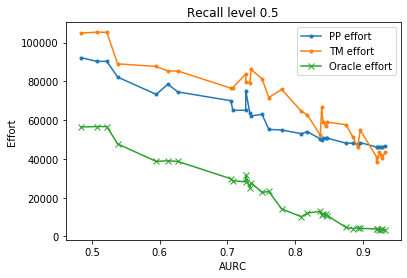

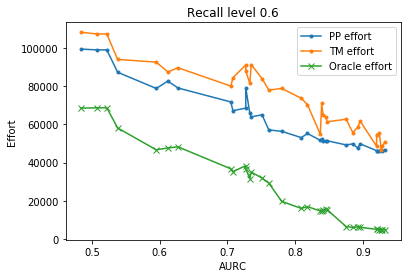

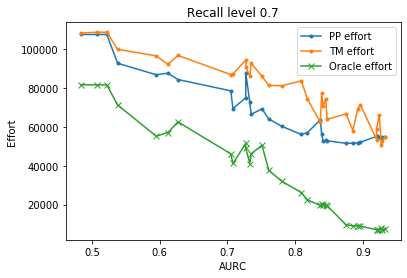

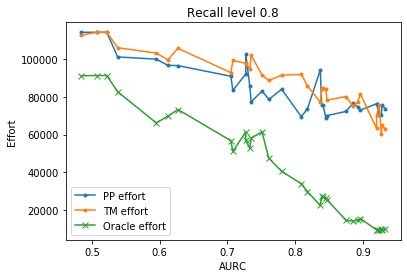

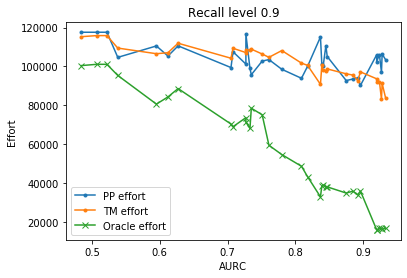

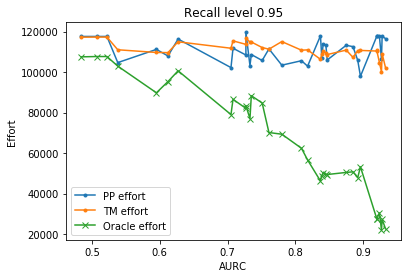

In [10]:
print_effort_graphs(0.95)

Probability level: 0.7


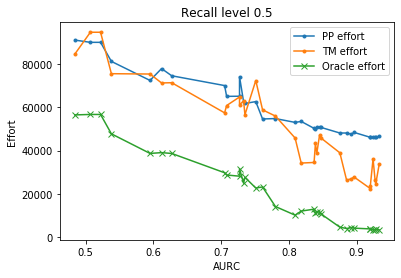

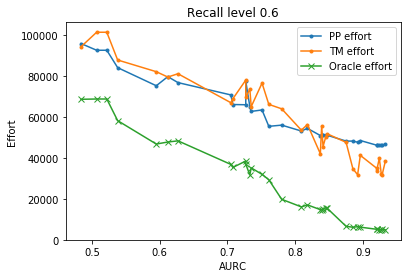

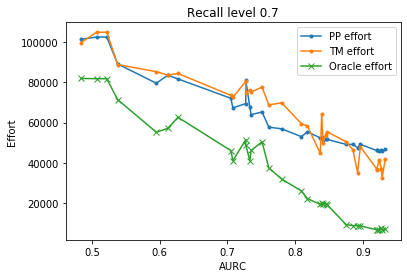

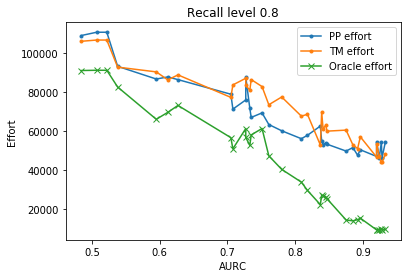

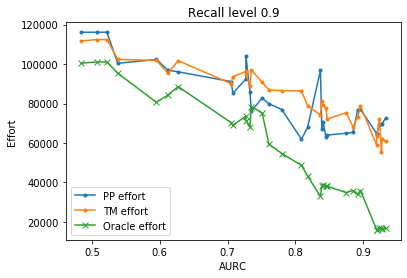

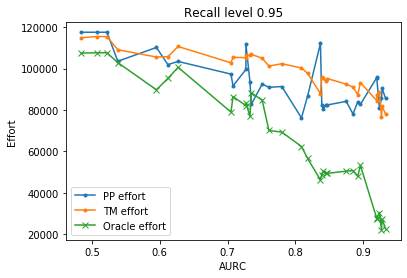

In [11]:
print_effort_graphs(0.7)